In [1]:
# Практична робота №3. Класифікація твітів за тональністю з використанням Word2Vec

import os
import re
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import ssl
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# ВИМКНЕННЯ SSL ПЕРЕВІРКИ ДЛЯ NLTK
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# NLTK_DATA
NLTK_DATA_PATH = 'nltk_data'
if os.path.exists(NLTK_DATA_PATH):
    nltk.data.path.append(NLTK_DATA_PATH)
    print(f"✓ Використовується локальна папка nltk_data: {os.path.abspath(NLTK_DATA_PATH)}")
else:
    print("✗ Папка nltk_data не знайдена")

# ПЕРЕВІРКА ТА ЗАВАНТАЖЕННЯ NLTK ДАНИХ
print("\nПеревірка NLTK ресурсів...")

def check_nltk_data():
    """Перевіряє та завантажує необхідні NLTK ресурси"""
    resources = {
        'punkt': 'tokenizers/punkt',
        'stopwords': 'corpora/stopwords'
    }
    
    for resource_name, resource_path in resources.items():
        try:
            nltk.data.find(resource_path)
            print(f"✓ {resource_name} знайдено")
        except LookupError:
            print(f"Завантаження {resource_name}...")
            try:
                nltk.download(resource_name, quiet=True)
                print(f"✓ {resource_name} завантажено")
            except Exception as e:
                print(f"✗ Помилка завантаження {resource_name}: {e}")

check_nltk_data()

# ПАРАМЕТРИ ЕКСПЕРИМЕНТУ
DATA_FILES = {
    'train': "Corona_NLP_train.csv",
    'test': "Corona_NLP_test.csv", 
    'single': "Corona_NLP.csv"
}

TEXT_COLUMNS = ["OriginalTweet", "Original Tweet", "OriginalTweet_text", "text", "tweet", "tweet_text"]
LABEL_COLUMNS = ["Sentiment", "Label", "label", "sentiment"]

MODEL_CONFIG = {
    'random_state': 42,
    'test_size': 0.2,
    'w2v_size': 100,
    'w2v_window': 5,
    'w2v_min_count': 2,
    'w2v_epochs': 10,
    'pca_options': [None, 50, 100, 200]
}

# ЗАВАНТАЖЕННЯ СТОП-СЛІВ
try:
    STOP_WORDS = set(stopwords.words("english"))
    print(f"\n✓ Завантажено {len(STOP_WORDS)} стоп-слів")
except Exception as e:
    print(f"\n✗ Не вдалося завантажити стоп-слова: {e}")
    # Резервний список стоп-слів
    STOP_WORDS = {
        'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", 
        "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 
        'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 
        'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 
        'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 
        'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 
        'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 
        'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 
        'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 
        'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 
        'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once'
    }
    print(f"✓ Використовуються резервні стоп-слова ({len(STOP_WORDS)} слів)")

print("\nПараметри експерименту налаштовано")

✓ Використовується локальна папка nltk_data: d:\Navchanja\4.1\ML\nltk_data

Перевірка NLTK ресурсів...
✓ punkt знайдено
✓ stopwords знайдено

✓ Завантажено 198 стоп-слів

Параметри експерименту налаштовано


In [2]:
# ФУНКЦІЇ ОБРОБКИ ТЕКСТУ

def text_cleaning(text_input):
    if not isinstance(text_input, str):
        return ""
    
    cleaned_text = text_input.lower()
    cleaned_text = re.sub(r"http\S+|www\.\S+", " ", cleaned_text)
    cleaned_text = re.sub(r"@\w+", " ", cleaned_text)
    cleaned_text = re.sub(r"#", " ", cleaned_text)
    cleaned_text = re.sub(r"[^a-zA-Z0-9\s']", " ", cleaned_text)
    cleaned_text = re.sub(r"\s+", " ", cleaned_text).strip()
    
    return cleaned_text

def text_tokenization(text_input):
    tokens = word_tokenize(str(text_input))
    filtered_tokens = [token for token in tokens 
                      if token.isalpha() and token not in STOP_WORDS and len(token) > 1]
    return filtered_tokens

def document_embedding(tokens_list, embedding_model, embedding_size):
    vectors = [embedding_model.wv[word] for word in tokens_list if word in embedding_model.wv]
    
    if len(vectors) == 0:
        return np.zeros(embedding_size, dtype=float)
    
    return np.mean(vectors, axis=0)

def identify_data_columns(dataframe_columns, possible_names):
    for column_name in possible_names:
        if column_name in dataframe_columns:
            return column_name
    return None

def normalize_dataset_columns(dataframe):
    available_columns = dataframe.columns
    
    text_column = identify_data_columns(available_columns, TEXT_COLUMNS)
    label_column = identify_data_columns(available_columns, LABEL_COLUMNS)
    
    if text_column is None or label_column is None:
        text_candidate, label_candidate = None, None
        
        for column in available_columns:
            column_lower = column.lower()
            if text_candidate is None and ("tweet" in column_lower or "text" in column_lower):
                text_candidate = column
            if label_candidate is None and ("sent" in column_lower or "label" in column_lower):
                label_candidate = column
                
        if text_candidate is None or label_candidate is None:
            raise ValueError(f"Не знайдено текстову або цільову колонку. Доступні: {list(available_columns)}")
        
        text_column, label_column = text_candidate, label_candidate
    
    return dataframe[[text_column, label_column]].dropna().rename(
        columns={text_column: "text", label_column: "label"})

In [3]:
# ЗАВАНТАЖЕННЯ ТА ПІДГОТОВКА ДАНИХ

print("Завантаження даних...")

def load_dataset():
    """Завантаження та підготовка датасету"""
    # Перевірка наявності файлів
    for file_type, file_name in DATA_FILES.items():
        if os.path.exists(file_name):
            print(f"✓ Знайдено {file_type}: {file_name}")
        else:
            print(f"✗ Не знайдено {file_type}: {file_name}")
    
    if os.path.exists(DATA_FILES['train']) and os.path.exists(DATA_FILES['test']):
        print("Завантаження окремих train/test файлів...")
        train_data = pd.read_csv(DATA_FILES['train'], encoding="latin1")
        test_data = pd.read_csv(DATA_FILES['test'], encoding="latin1")
    elif os.path.exists(DATA_FILES['single']):
        print("Завантаження єдиного файлу...")
        full_dataset = pd.read_csv(DATA_FILES['single'], encoding="utf-8", errors="replace")
        full_dataset = normalize_dataset_columns(full_dataset)
        train_data, test_data = train_test_split(
            full_dataset, 
            test_size=MODEL_CONFIG['test_size'], 
            random_state=MODEL_CONFIG['random_state'], 
            stratify=full_dataset["label"]
        )
    else:
        print("Файли не знайдені. Перевірте назви файлів.")
        return None, None
    
    train_data = normalize_dataset_columns(train_data)
    test_data = normalize_dataset_columns(test_data)
    
    return train_data, test_data

train_data, test_data = load_dataset()

if train_data is not None:
    print(f"Розмір тренувальних даних: {len(train_data)}")
    print(f"Розмір тестових даних: {len(test_data)}")
    print("\nПерші 3 рядки тренувальних даних:")
    print(train_data.head(3))
else:
    print("Не вдалося завантажити дані")

Завантаження даних...
✓ Знайдено train: Corona_NLP_train.csv
✓ Знайдено test: Corona_NLP_test.csv
✗ Не знайдено single: Corona_NLP.csv
Завантаження окремих train/test файлів...
Розмір тренувальних даних: 41157
Розмір тестових даних: 3798

Перші 3 рядки тренувальних даних:
                                                text     label
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...   Neutral
1  advice Talk to your neighbours family to excha...  Positive
2  Coronavirus Australia: Woolworths to give elde...  Positive


In [4]:
# ПЕРЕТВОРЕННЯ МІТОК У ТРИ КАТЕГОРІЇ

def convert_to_three_categories(label):
    """Групування міток у три основні категорії"""
    label_str = str(label).strip().lower()
    
    if label_str in ("positive", "pos", "p", "extremely positive"):
        return "Positive"
    if label_str in ("negative", "neg", "n", "extremely negative"):
        return "Negative"
    if "positive" in label_str:
        return "Positive"
    if "negative" in label_str:
        return "Negative"
    if label_str in ("neutral", "neut", "other", "mixed", "irrelevant", "normal"):
        return "Other"
    
    return "Other"

if train_data is not None:
    train_data["sentiment_category"] = train_data["label"].apply(convert_to_three_categories)
    test_data["sentiment_category"] = test_data["label"].apply(convert_to_three_categories)

    print("Розподіл категорій у тренувальних даних:")
    print(train_data["sentiment_category"].value_counts())
    
    print("\nРозподіл категорій у тестових даних:")
    print(test_data["sentiment_category"].value_counts())
else:
    print("Дані не завантажено")

Розподіл категорій у тренувальних даних:
sentiment_category
Positive    18046
Negative    15398
Other        7713
Name: count, dtype: int64

Розподіл категорій у тестових даних:
sentiment_category
Negative    1633
Positive    1546
Other        619
Name: count, dtype: int64


In [5]:
#  ТОКЕНІЗАЦІЯ ТЕКСТІВ

if train_data is not None:
    print("Токенізація текстів...")

    # Очищення текстів
    train_data["cleaned_text"] = train_data["text"].apply(text_cleaning)
    test_data["cleaned_text"] = test_data["text"].apply(text_cleaning)

    # Перевірка структури папки nltk_data
    print("Перевірка структури nltk_data...")
    nltk_path = 'nltk_data'
    if os.path.exists(nltk_path):
        for root, dirs, files in os.walk(nltk_path):
            level = root.replace(nltk_path, '').count(os.sep)
            indent = ' ' * 2 * level
            print(f'{indent}{os.path.basename(root)}/')
            subindent = ' ' * 2 * (level + 1)
            for file in files[:5]:  
                print(f'{subindent}{file}')
            if len(files) > 5:
                print(f'{subindent}... ще {len(files) - 5} файлів')

    def simple_tokenization(text_input):
        """Проста токенізація без NLTK"""
        if not isinstance(text_input, str):
            return []
        
        # Розділяємо по пробілах та фільтруємо
        tokens = text_input.split()
        filtered_tokens = [token for token in tokens 
                          if token.isalpha() and token not in STOP_WORDS and len(token) > 1]
        return filtered_tokens

    print("Використання простої токенізації...")
    train_data["tokenized"] = train_data["cleaned_text"].apply(simple_tokenization)
    test_data["tokenized"] = test_data["cleaned_text"].apply(simple_tokenization)

    # Фільтрація порожніх документів
    initial_train_size = len(train_data)
    initial_test_size = len(test_data)

    train_data = train_data[train_data["tokenized"].map(len) > 0].reset_index(drop=True)
    test_data = test_data[test_data["tokenized"].map(len) > 0].reset_index(drop=True)

    print(f"Після фільтрації - тренувальні: {len(train_data)} (втрачено {initial_train_size - len(train_data)})")
    print(f"Після фільтрації - тестові: {len(test_data)} (втрачено {initial_test_size - len(test_data)})")

    # Перевірка розподілу після фільтрації
    print("\nРозподіл категорій після фільтрації:")
    print(train_data["sentiment_category"].value_counts())
    
    print("\nПриклад токенізації:")
    sample_idx = 0
    for i in range(len(train_data)):
        if len(train_data.iloc[i]["tokenized"]) > 0:
            sample_idx = i
            break
            
    sample_text = train_data.iloc[sample_idx]["text"]
    sample_cleaned = train_data.iloc[sample_idx]["cleaned_text"]
    sample_tokens = train_data.iloc[sample_idx]["tokenized"]
    print(f"Оригінальний текст: {sample_text[:100]}...")
    print(f"Очищений текст: {sample_cleaned[:100]}...")
    print(f"Токени: {sample_tokens[:10]}...")
    print(f"Всього токенів: {len(sample_tokens)}")
else:
    print("Дані не завантажено")

Токенізація текстів...
Перевірка структури nltk_data...
nltk_data/
  punkt/
    .DS_Store
    czech.pickle
    danish.pickle
    dutch.pickle
    english.pickle
    ... ще 16 файлів
    PY3/
      czech.pickle
      danish.pickle
      dutch.pickle
      english.pickle
      estonian.pickle
      ... ще 15 файлів
  stopwords/
    albanian
    arabic
    azerbaijani
    basque
    belarusian
    ... ще 28 файлів
Використання простої токенізації...
Після фільтрації - тренувальні: 41123 (втрачено 34)
Після фільтрації - тестові: 3796 (втрачено 2)

Розподіл категорій після фільтрації:
sentiment_category
Positive    18044
Negative    15397
Other        7682
Name: count, dtype: int64

Приклад токенізації:
Оригінальний текст: advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbe...
Очищений текст: advice talk to your neighbours family to exchange phone numbers create contact list with phone numbe...
Токени: ['advice', 'talk', 'neighbours', 'family

In [6]:
# НАВЧАННЯ WORD2VEC МОДЕЛІ

if train_data is not None:
    print("Навчання Word2Vec моделі...")

    # Підготовка всіх речень для тренування
    all_sentences = list(train_data["tokenized"]) + list(test_data["tokenized"])

    print(f"Загальна кількість речень для тренування: {len(all_sentences)}")
    print(f"Загальна кількість унікальних слів: {len(set([word for sentence in all_sentences for word in sentence]))}")

    # Навчання Word2Vec моделі
    word2vec_model = Word2Vec(
        sentences=all_sentences,
        vector_size=MODEL_CONFIG['w2v_size'],
        window=MODEL_CONFIG['w2v_window'],
        min_count=MODEL_CONFIG['w2v_min_count'],
        workers=4,
        epochs=MODEL_CONFIG['w2v_epochs'],
        seed=MODEL_CONFIG['random_state']
    )

    # Збереження моделі
    joblib.dump(word2vec_model, "word2vec_model.joblib")
    print(f"Word2Vec модель навчена. Розмір словника: {len(word2vec_model.wv.index_to_key)}")

    # Перевірка якості векторів
    if len(word2vec_model.wv.index_to_key) > 0:
        sample_word = word2vec_model.wv.index_to_key[0]
        print(f"Приклад вектора для слова '{sample_word}': {word2vec_model.wv[sample_word][:5]}...")
        
        # Пошук схожих слів
        if len(word2vec_model.wv.index_to_key) > 10:
            test_word = word2vec_model.wv.index_to_key[5]
            similar_words = word2vec_model.wv.most_similar(test_word, topn=3)
            print(f"Слова схожі на '{test_word}': {similar_words}")
    else:
        print("Увага: модель не містить слів у словнику")
else:
    print("Дані не завантажено")

Навчання Word2Vec моделі...
Загальна кількість речень для тренування: 44919
Загальна кількість унікальних слів: 44433
Word2Vec модель навчена. Розмір словника: 20933
Приклад вектора для слова 'coronavirus': [ 0.96171695  0.6054871   1.0659809  -1.2749301  -0.00736187]...
Слова схожі на 'supermarket': [('excercise', 0.6384639739990234), ('supermarkets', 0.6145210266113281), ('round', 0.5906413793563843)]


In [7]:
print("train_data:", type(train_data))
print("test_data:", type(test_data))

# СТВОРЕННЯ ВЕКТОРНИХ ПРЕДСТАВЛЕНЬ ДОКУМЕНТІВ

print("Створення векторних представлень...")

X_train_vectors = np.vstack(
    train_data["tokenized"].apply(
        lambda tokens: document_embedding(tokens, word2vec_model, MODEL_CONFIG['w2v_size'])
    ).values
)

X_test_vectors = np.vstack(
    test_data["tokenized"].apply(
        lambda tokens: document_embedding(tokens, word2vec_model, MODEL_CONFIG['w2v_size'])
    ).values
)

y_train_labels = train_data["sentiment_category"].values
y_test_labels = test_data["sentiment_category"].values

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_labels)
y_test_encoded = label_encoder.transform(y_test_labels)

print("Кодування категорій:", dict(enumerate(label_encoder.classes_)))

train_data: <class 'pandas.core.frame.DataFrame'>
test_data: <class 'pandas.core.frame.DataFrame'>
Створення векторних представлень...
Кодування категорій: {0: 'Negative', 1: 'Other', 2: 'Positive'}


In [8]:
# ВИЗНАЧЕННЯ КЛАСИФІКАТОРІВ ТА ФУНКЦІЙ ВІЗУАЛІЗАЦІЇ

classifiers = {
    "LogisticRegression": LogisticRegression(
        max_iter=1000, 
        random_state=MODEL_CONFIG['random_state']
    ),
    "LinearSVM": LinearSVC(
        random_state=MODEL_CONFIG['random_state'],
        max_iter=10000
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=100,
        random_state=MODEL_CONFIG['random_state']
    ),
    "GaussianNB": GaussianNB()
}

def create_confusion_matrix_plot(conf_matrix, class_labels, plot_title, filename=None, display=True):
    """Створення візуалізації матриці плутанини"""
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=class_labels, 
                yticklabels=class_labels, cmap="YlOrRd", cbar=False)
    plt.ylabel("Справжні значення")
    plt.xlabel("Прогнозовані значення")
    plt.title(plot_title)
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    if display:
        plt.show()
    else:
        plt.close()

print("Класифікатори та функції візуалізації готові")

Класифікатори та функції візуалізації готові


Початок експериментів з класифікацією...

Експеримент: Без_PCA
Навчання моделі: LogisticRegression з Без_PCA


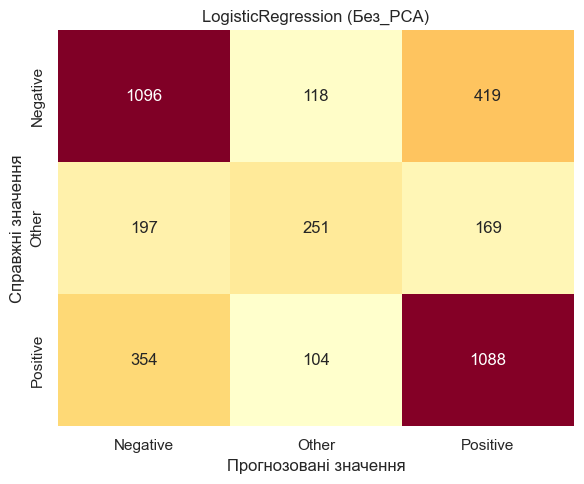

✓ LogisticRegression | Точність: 0.6415 | Збережено: pipeline_LogisticRegression_Без_PCA.joblib
Навчання моделі: LinearSVM з Без_PCA
✓ LinearSVM | Точність: 0.6375 | Збережено: pipeline_LinearSVM_Без_PCA.joblib
Навчання моделі: RandomForest з Без_PCA
✓ RandomForest | Точність: 0.6070 | Збережено: pipeline_RandomForest_Без_PCA.joblib
Навчання моделі: GaussianNB з Без_PCA
✓ GaussianNB | Точність: 0.5387 | Збережено: pipeline_GaussianNB_Без_PCA.joblib

Експеримент: PCA_50
Навчання моделі: LogisticRegression з PCA_50


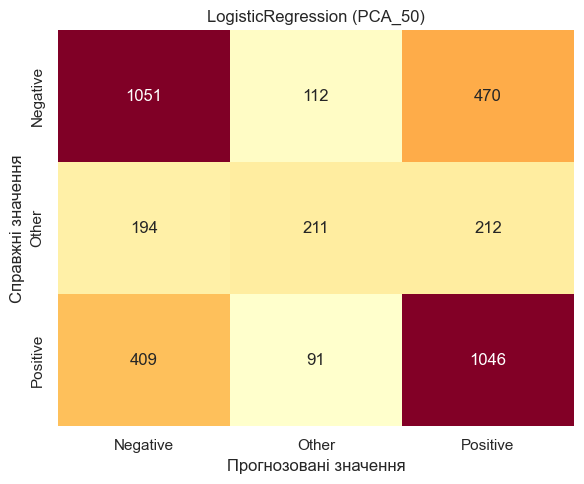

✓ LogisticRegression | Точність: 0.6080 | Збережено: pipeline_LogisticRegression_PCA_50.joblib
Навчання моделі: LinearSVM з PCA_50
✓ LinearSVM | Точність: 0.5985 | Збережено: pipeline_LinearSVM_PCA_50.joblib
Навчання моделі: RandomForest з PCA_50
✓ RandomForest | Точність: 0.5991 | Збережено: pipeline_RandomForest_PCA_50.joblib
Навчання моделі: GaussianNB з PCA_50
✓ GaussianNB | Точність: 0.5616 | Збережено: pipeline_GaussianNB_PCA_50.joblib

Експеримент: PCA_100
Навчання моделі: LogisticRegression з PCA_100


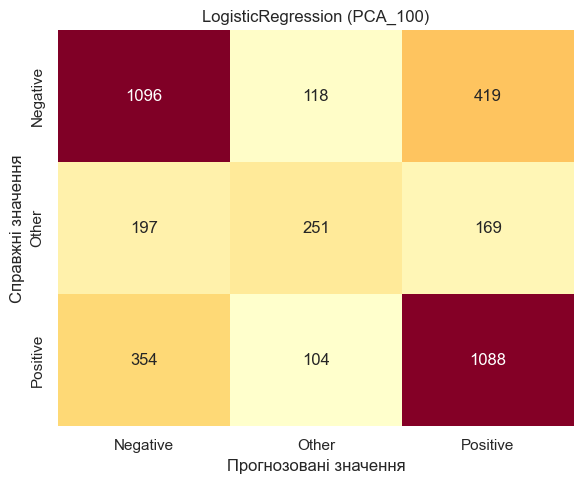

✓ LogisticRegression | Точність: 0.6415 | Збережено: pipeline_LogisticRegression_PCA_100.joblib
Навчання моделі: LinearSVM з PCA_100
✓ LinearSVM | Точність: 0.6375 | Збережено: pipeline_LinearSVM_PCA_100.joblib
Навчання моделі: RandomForest з PCA_100
✓ RandomForest | Точність: 0.6070 | Збережено: pipeline_RandomForest_PCA_100.joblib
Навчання моделі: GaussianNB з PCA_100
✓ GaussianNB | Точність: 0.5387 | Збережено: pipeline_GaussianNB_PCA_100.joblib

Експеримент: PCA_200
Навчання моделі: LogisticRegression з PCA_200


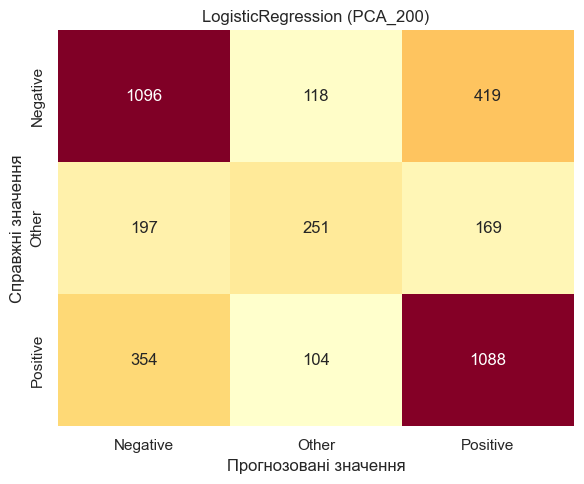

✓ LogisticRegression | Точність: 0.6415 | Збережено: pipeline_LogisticRegression_PCA_200.joblib
Навчання моделі: LinearSVM з PCA_200
✓ LinearSVM | Точність: 0.6375 | Збережено: pipeline_LinearSVM_PCA_200.joblib
Навчання моделі: RandomForest з PCA_200
✓ RandomForest | Точність: 0.6070 | Збережено: pipeline_RandomForest_PCA_200.joblib
Навчання моделі: GaussianNB з PCA_200
✓ GaussianNB | Точність: 0.5387 | Збережено: pipeline_GaussianNB_PCA_200.joblib

Експерименти завершено!


In [9]:
# ЕКСПЕРИМЕНТИ З РІЗНИМИ КОНФІГУРАЦІЯМИ PCA

if train_data is not None and 'X_train_vectors' in locals():
    print("Початок експериментів з класифікацією...")
    experiment_results = []

    for pca_components in MODEL_CONFIG['pca_options']:
        pca_description = "Без_PCA" if pca_components is None else f"PCA_{pca_components}"
        
        print("\n" + "="*50)
        print(f"Експеримент: {pca_description}")
        print("="*50)
        
        for classifier_name, classifier_model in classifiers.items():
            print(f"Навчання моделі: {classifier_name} з {pca_description}")
            
            try:
                pipeline_steps = []
                if pca_components is not None and X_train_vectors.shape[1] > pca_components:
                    pipeline_steps.append(("pca", PCA(
                        n_components=min(pca_components, X_train_vectors.shape[1]), 
                        random_state=MODEL_CONFIG['random_state']
                    )))
                
                pipeline_steps.append(("classifier", classifier_model))
                
                model_pipeline = Pipeline(pipeline_steps)
                model_pipeline.fit(X_train_vectors, y_train_encoded)
                
                predictions = model_pipeline.predict(X_test_vectors)

                accuracy = accuracy_score(y_test_encoded, predictions)
                metrics_report = classification_report(
                    y_test_encoded, predictions, 
                    target_names=label_encoder.classes_, 
                    output_dict=True, 
                    zero_division=0
                )
                
                conf_matrix = confusion_matrix(y_test_encoded, predictions)

                result_entry = {
                    "модель": classifier_name, 
                    "pca": "None" if pca_components is None else pca_components, 
                    "точність": accuracy
                }
                
                for category in label_encoder.classes_:
                    category_metrics = metrics_report.get(category, {
                        "precision": 0, "recall": 0, "f1-score": 0, "support": 0
                    })
                    result_entry[f"{category}_precision"] = category_metrics["precision"]
                    result_entry[f"{category}_recall"] = category_metrics["recall"]
                    result_entry[f"{category}_f1"] = category_metrics["f1-score"]
                    result_entry[f"{category}_support"] = category_metrics.get("support", 0)
                
                experiment_results.append(result_entry)

                # Візуалізація для LogisticRegression
                if classifier_name == "LogisticRegression":
                    create_confusion_matrix_plot(
                        conf_matrix, 
                        class_labels=label_encoder.classes_, 
                        plot_title=f"{classifier_name} ({pca_description})", 
                        filename=None, 
                        display=True
                    )

                # Збереження моделі
                model_filename = f"pipeline_{classifier_name}_{pca_description}.joblib"
                joblib.dump(model_pipeline, model_filename)
                
                print(f"✓ {classifier_name} | Точність: {accuracy:.4f} | Збережено: {model_filename}")
                
            except Exception as e:
                print(f"✗ Помилка у {classifier_name} з {pca_description}: {str(e)}")
                continue

    print("\nЕксперименти завершено!")
else:
    print("Дані не готові для експериментів")

In [10]:
# ЗБЕРЕЖЕННЯ РЕЗУЛЬТАТІВ

results_dataframe = pd.DataFrame(experiment_results).sort_values(
    by=["модель", "pca"]).reset_index(drop=True)

results_dataframe.to_csv("результати_експерименту.csv", index=False)
print("Результати збережено у файл: результати_експерименту.csv")
results_dataframe

Результати збережено у файл: результати_експерименту.csv


,модель,pca,точність,Negative_precision,Negative_recall,Negative_f1,Negative_support,Other_precision,Other_recall,Other_f1,Other_support,Positive_precision,Positive_recall,Positive_f1,Positive_support
0,GaussianNB,50,0.561644,0.593010,0.644213,0.617552,1633.0,0.388218,0.416532,0.401876,617.0,0.605147,0.532342,0.566414,1546.0
1,GaussianNB,100,0.538725,0.580500,0.554195,0.567043,1633.0,0.403727,0.421394,0.412371,617.0,0.552417,0.569211,0.560688,1546.0
2,GaussianNB,200,0.538725,0.580500,0.554195,0.567043,1633.0,0.403727,0.421394,0.412371,617.0,0.552417,0.569211,0.560688,1546.0
3,GaussianNB,None,0.538725,0.580500,0.554195,0.567043,1633.0,0.403727,0.421394,0.412371,617.0,0.552417,0.569211,0.560688,1546.0
4,LinearSVM,50,0.598525,0.619661,0.648500,0.633752,1633.0,0.505988,0.273906,0.355415,617.0,0.595550,0.675291,0.632919,1546.0
5,LinearSVM,100,0.637513,0.658228,0.668708,0.663426,1633.0,0.560976,0.372771,0.447907,617.0,0.635785,0.710220,0.670944,1546.0
6,LinearSVM,200,0.637513,0.658228,0.668708,0.663426,1633.0,0.560976,0.372771,0.447907,617.0,0.635785,0.710220,0.670944,1546.0
7,LinearSVM,None,0.637513,0.658228,0.668708,0.663426,1633.0,0.560976,0.372771,0.447907,617.0,0.635785,0.710220,0.670944,1546.0
8,LogisticRegression,50,0.608008,0.635429,0.643601,0.639489,1633.0,0.509662,0.341977,0.409311,617.0,0.605324,0.676585,0.638974,1546.0
9,LogisticRegression,100,0.641465,0.665452,0.671157,0.668293,1633.0,0.530655,0.406807,0.460550,617.0,0.649165,0.703752,0.675357,1546.0


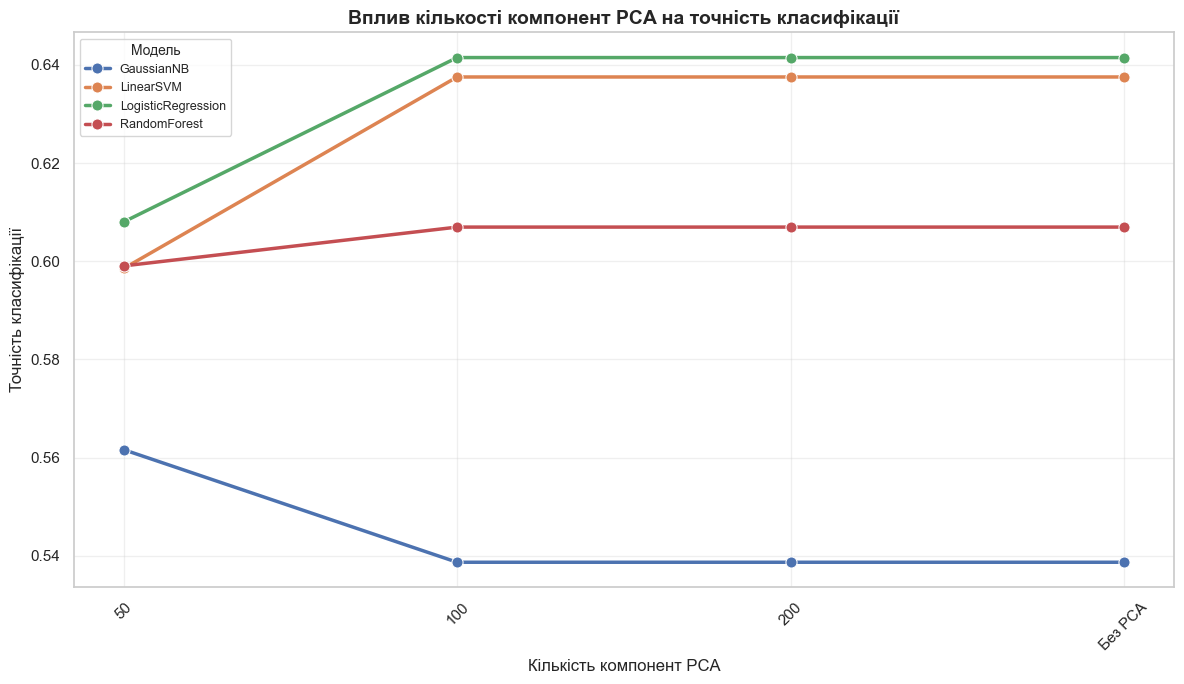

In [11]:
# ВІЗУАЛІЗАЦІЯ ВПЛИВУ PCA НА ТОЧНІСТЬ

results_dataframe['pca_візуалізація'] = results_dataframe['pca'].apply(
    lambda x: 'Без PCA' if x == 'None' else str(x))

plt.figure(figsize=(12, 7))
sns.lineplot(
    data=results_dataframe,
    x='pca_візуалізація', 
    y='точність', 
    hue='модель', 
    marker='o',
    linewidth=2.5,
    markersize=8
)

plt.title("Вплив кількості компонент PCA на точність класифікації", fontsize=14, fontweight='bold')
plt.xlabel("Кількість компонент PCA", fontsize=12)
plt.ylabel("Точність класифікації", fontsize=12)
plt.legend(title='Модель', title_fontsize=10, fontsize=9)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# АНАЛІЗ НАЙКРАЩИХ РЕЗУЛЬТАТІВ

найкращий_результат = results_dataframe.loc[results_dataframe["точність"].idxmax()]

print("НАЙКРАЩА КОНФІГУРАЦІЯ:")
print(f"Модель: {найкращий_результат['модель']}")
print(f"PCA: {найкращий_результат['pca']}")
print(f"Точність: {найкращий_результат['точність']:.4f}")

# Аналіз впливу PCA на різні моделі
точність_без_pca = results_dataframe[results_dataframe["pca"] == "None"].groupby("модель")["точність"].mean()
точність_з_pca = results_dataframe[results_dataframe["pca"] != "None"].groupby("модель")["точність"].mean()

print("\nСЕРЕДНЯ ТОЧНІСТЬ БЕЗ PCA:")
print(точність_без_pca)

print("\nСЕРЕДНЯ ТОЧНІСТЬ З PCA:")
print(точність_з_pca)

НАЙКРАЩА КОНФІГУРАЦІЯ:
Модель: LogisticRegression
PCA: 100
Точність: 0.6415

СЕРЕДНЯ ТОЧНІСТЬ БЕЗ PCA:
модель
GaussianNB            0.538725
LinearSVM             0.637513
LogisticRegression    0.641465
RandomForest          0.606955
Name: точність, dtype: float64

СЕРЕДНЯ ТОЧНІСТЬ З PCA:
модель
GaussianNB            0.546365
LinearSVM             0.624517
LogisticRegression    0.630313
RandomForest          0.604320
Name: точність, dtype: float64


ПОРІВНЯЛЬНА ХАРАКТЕРИСТИКА МОДЕЛЕЙ:


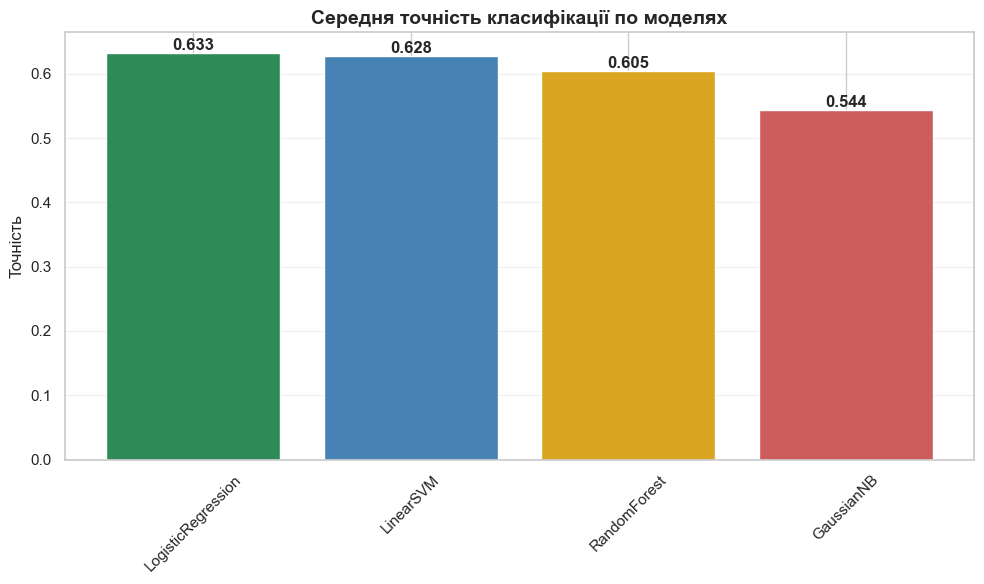


Рейтинг моделей за середньою точністю:
1. LogisticRegression: 0.6331
2. LinearSVM: 0.6278
3. RandomForest: 0.6050
4. GaussianNB: 0.5445


In [13]:
# ПОРІВНЯЛЬНИЙ АНАЛІЗ МОДЕЛЕЙ

print("ПОРІВНЯЛЬНА ХАРАКТЕРИСТИКА МОДЕЛЕЙ:")

середня_точність = results_dataframe.groupby('модель')['точність'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
bars = plt.bar(середня_точність.index, середня_точність.values, 
               color=['#2E8B57', '#4682B4', '#DAA520', '#CD5C5C'])

plt.title('Середня точність класифікації по моделях', fontsize=14, fontweight='bold')
plt.ylabel('Точність', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nРейтинг моделей за середньою точністю:")
for i, (model, accuracy) in enumerate(середня_точність.items(), 1):
    print(f"{i}. {model}: {accuracy:.4f}")